<a href="https://colab.research.google.com/github/PiotMik/spread-options/blob/feature%2FNotebook_Copulas/Copulas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bivariate copulas for crack spread option pricing


In [122]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.covariance import EllipticEnvelope

from google.colab import files
sns.set()
plt.rcParams['figure.figsize'] = (14, 7)

In [ ]:
uploaded = files.upload()

## Data
Dane pochodzą z https://www.macrotrends.net/.
Ściągnęliśmy kilka lat dziennych obserwacji:
* [Closing price for No. 2 Heating Oil: New York Harbor](https://www.macrotrends.net/2479/heating-oil-prices-historical-chart-data). The prices shown are in U.S. dollars.
* [West Texas Intermediate (WTI or NYMEX) crude oil prices per barrel](https://www.macrotrends.net/1369/crude-oil-price-history-chart). The price of oil shown is adjusted for inflation using the headline CPI and is shown by default on a logarithmic scale

In [65]:
ho_df = pd.read_csv('HO.csv', skiprows=13, index_col='date', parse_dates=True)
co_df = pd.read_csv('CO.csv', skiprows=13, index_col='date', parse_dates=True)

ho_df = ho_df.rename(columns={" value": "HeatingOil"})
ho_df.HeatingOil = ho_df.HeatingOil*42
co_df = co_df.rename(columns={" value": "CrudeOil"})

spread_df = pd.DataFrame(ho_df.HeatingOil - co_df.CrudeOil)
spread_df = spread_df.rename(columns={0: "Spread"})

pricing_df = pd.concat([ho_df, co_df, spread_df], axis=1)
pricing_df.head()

,HeatingOil,CrudeOil,Spread
date,,,
2008-12-29,53.76,39.89,13.87
2008-12-30,53.76,38.95,14.81
2008-12-31,55.02,44.60,10.42
2009-01-02,61.32,46.17,15.15
2009-01-05,65.10,48.61,16.49


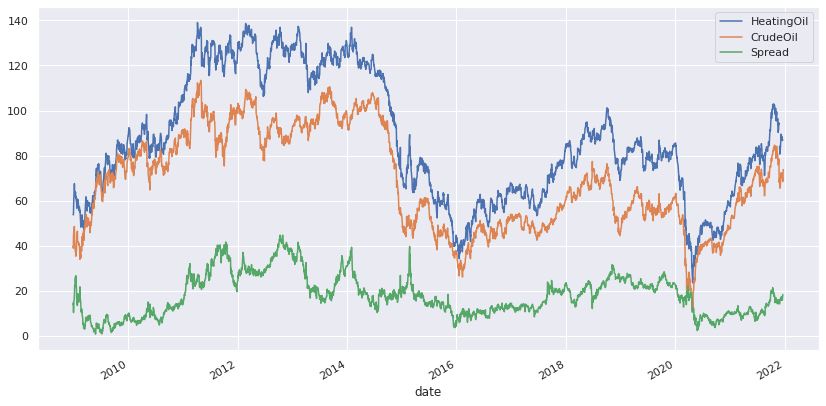

In [66]:
pricing_df.plot()

## Logreturns analysis

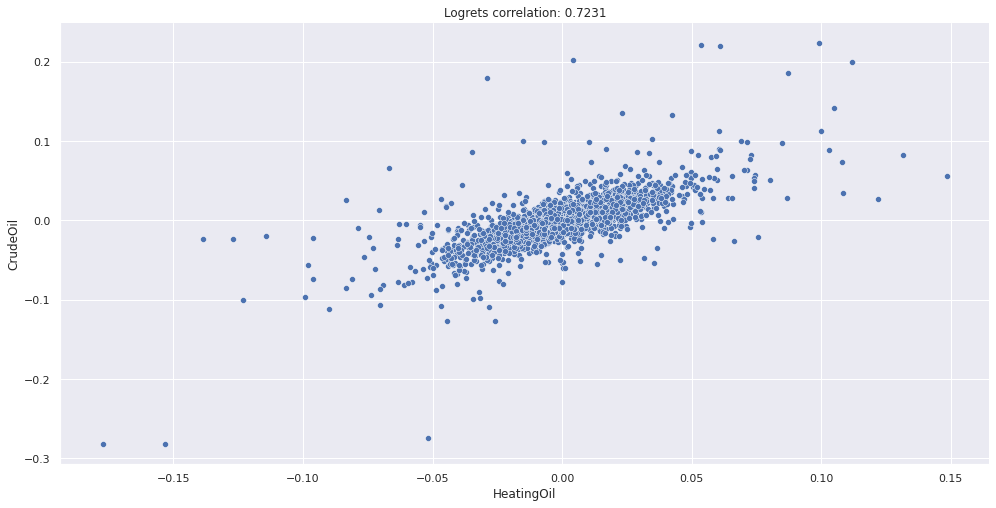

In [139]:
logrets_df = np.log(pricing_df).diff().dropna()
sns.relplot(data = logrets_df, x="HeatingOil", y="CrudeOil", height = 7, aspect=2)
corr = logrets_df.loc[:, ["HeatingOil", "CrudeOil"]].corr().iloc[1, 0]
_=plt.title(f"Logrets correlation: {corr:.4f}")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but EllipticEnvelope was fitted with feature names
  "X does not have valid feature names, but"


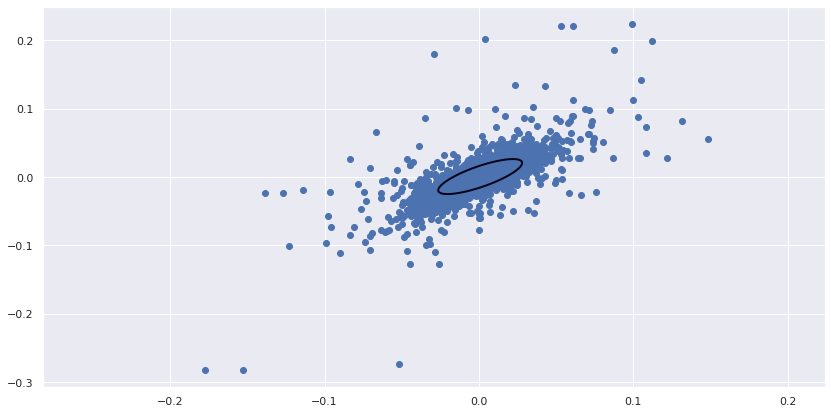

In [131]:
clf = EllipticEnvelope(contamination=0.25)
clf.fit(logrets_df.loc[:, ['CrudeOil', 'HeatingOil']])
xx1, yy1 = np.meshgrid(np.linspace(logrets_df.CrudeOil.min(), logrets_df.CrudeOil.max(), 500),
                       np.linspace(logrets_df.HeatingOil.min(), logrets_df.HeatingOil.max(), 500))
plt.figure(1)
Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
Z1 = Z1.reshape(xx1.shape)
plt.contour(xx1, yy1, Z1, levels=[1], linewidths=2)
plt.scatter(x = logrets_df.HeatingOil, y = logrets_df.CrudeOil)

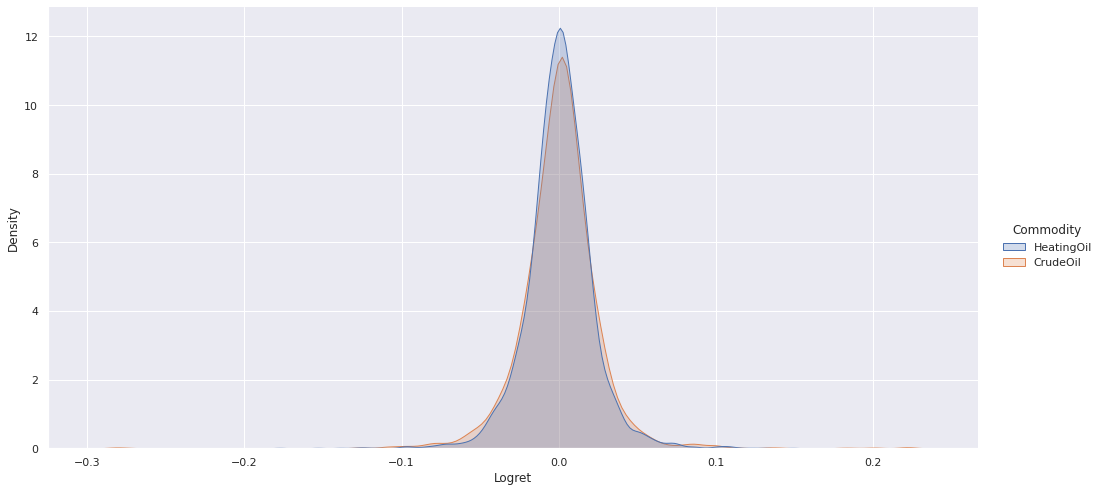

In [150]:
logrets_df_long = logrets_df.melt(var_name="Commodity", value_name= "Logret")

sns.displot(logrets_df.loc[:, ['HeatingOil', 'CrudeOil']].melt(var_name="Commodity", 
                                                               value_name= "Logret"),
            x="Logret", kind="kde", fill=True, hue='Commodity', height=7, aspect=2)

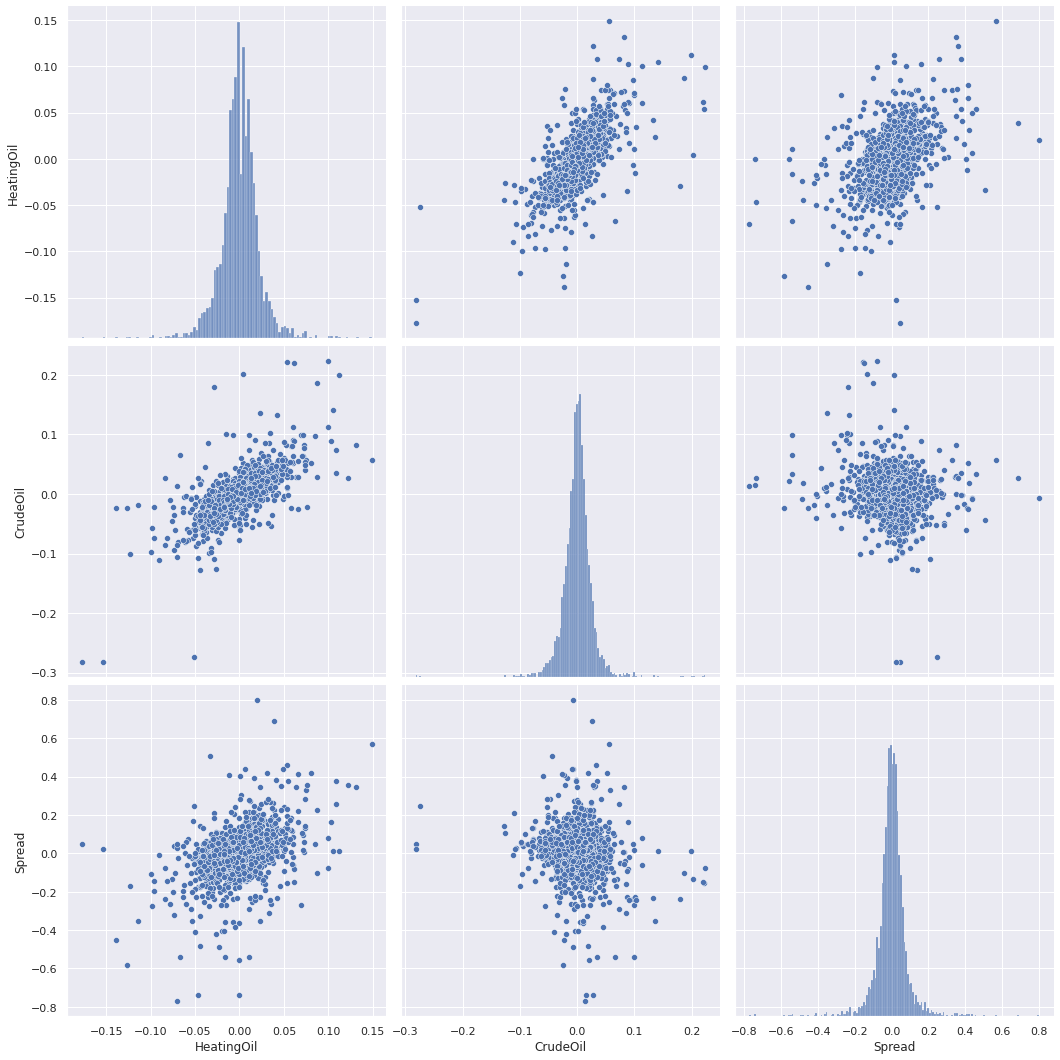

In [158]:
sns.pairplot(logrets_df, height=5, aspect=1)